## Работа с временными рядами, прогноз спроса такси

На основании исторических данных о заказах такси необходимо спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

В рамках работ нам необходимо:
1. Загрузить и изучить данные
2. Проанализировать их с точки зрения трендов и сезонности
3. Подобрать необходимые параметры отстающих значений временого рядя в признаках и интервала скользящего среднего
4. Обучить несколько моделей и для подобрали гипперпараметры
# 1. Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

Загрузим данные и ресемплируем их по часу и дню:

In [2]:
df = pd.read_csv('df', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df_resample_D = df.resample('1D').sum()
df = df.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


#### Перед нами данные по количеству заказов такси с марта по август 2018 года. Взглянем на них поробнее

# 2. Анализ

Рассмотрим тренды, сезонность и остатки данных при ресемплировании по дням:

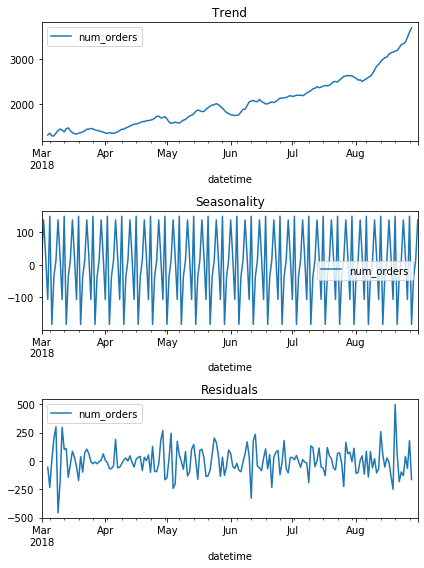

In [3]:
decomposed = seasonal_decompose(df_resample_D)

plt.figure(figsize=(6,8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Сезонность внутри месяца:

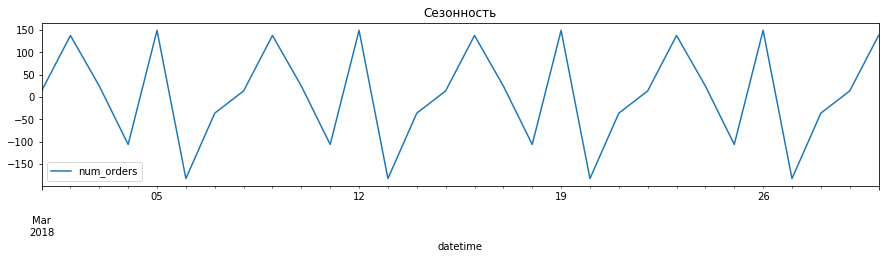

In [4]:
decomposed.seasonal['2018-03-01':'2018-03-30'].plot(figsize=(15,3))
plt.title('Сезонность')
plt.show()

Сравним показатель сезонности с реальным графиком заказов:

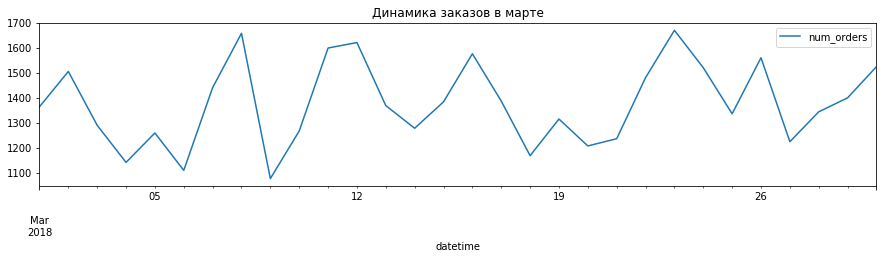

In [5]:
df_resample_D['2018-03-01':'2018-03-30'].plot(figsize=(15, 3))
plt.title('Динамика заказов в марте')
plt.show()

Получается, что функция seasonal отражает закономерности более явно на графике, как, например, резкое понижение заказов по вторникам, и может не совпадать с текущими значениями

Кроме того, можем выделить:
- уверенный рост заказов к лету, это можно связать с ростом активности людей в этом периоде в целом
- спад запросов в начале недели с поъдемом к пятнице и последущющим уменьшением. Возможно это связано с тем, что будни на такси совершается большое кличество поездок по работе, тогда как в выходные люди отдыхают

Календарь на март 2018:
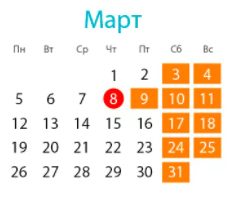

# 3. Обучение

In [6]:
def split(data):
    X = data.drop(['num_orders'], axis=1)
    Y = data['num_orders']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=123455)
    return X_train, X_test, Y_train, Y_test

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
def rmse(Y_test, predicted):
    return (mean_squared_error(Y_test, predicted)**0.5).round(2)

def rmse_gridsearch(score_best):
    return (((score_best)*(-1))**0.5).round(2)

def fit_predict(model, X_train, Y_train, X_test):
    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    return predicted

def run_gridsearch(model, params, X, Y):
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
    grid.fit(X, Y)

    print(grid.best_params_)
    print(rmse_gridsearch(grid.best_score_))

### Подбор параметров lag и rolling
Для начала добавим в данные столбцы с месяцем, числом месяца и днем недели, а затем переберем разные значения lag(количество смещенных позиций в признаках) и rolling (интервал скользящего среднего)

In [7]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

In [8]:
lag_all = []
rolling_all = []
rmse_all = []
for max_lag in range(1, 40, 1):
    for rolling_mean_size in range (1, 151, 5):
        df_ = df.copy()
        df_['rolling_mean'] = df_['num_orders'].shift().rolling(rolling_mean_size).mean()
        
        for lag in range(1, max_lag + 1):
            df_['lag_{}'.format(lag)] = df_['num_orders'].shift(lag)
        
        df_ = df_.dropna()
        X_train, X_test, Y_train, Y_test = split(df_)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)
        pred = model.predict(X_test)
        
        lag_all.append(max_lag)
        rolling_all.append(rolling_mean_size)
        rmse_all.append(rmse(Y_test, pred))

In [9]:
result = pd.DataFrame({'lag': lag_all, 'rolling': rolling_all, 'RMSE': rmse_all} )
result.sort_values('RMSE').head(10)

,lag,rolling,RMSE
1135,38,126,44.40
1165,39,126,44.43
1105,37,126,44.48
1075,36,126,44.51
985,33,126,44.57
1134,38,121,44.64
1045,35,126,44.64
1164,39,121,44.68
1015,34,126,44.68
1104,37,121,44.77


#### Зависимость RMSRE и lag / rolling_mean_size

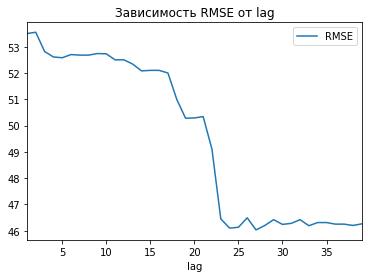

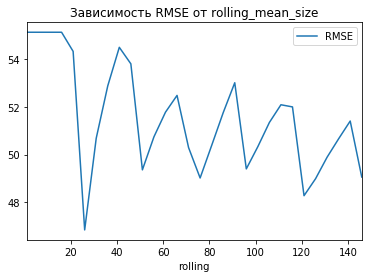

In [25]:
result.query('rolling == 71').pivot_table(index='lag', values='RMSE', aggfunc='mean').plot()
plt.title('Зависимость RMSE от lag')
result.query('lag == 20').pivot_table(index='rolling', values='RMSE', aggfunc='mean').plot()
plt.title('Зависимость RMSE от rolling_mean_size')
plt.show()

- при увеличении количества lag до ~23 RMSE уменьшается до 45-46, после чего колеблется примерно на одном уровне
- Значения RMSЕ сильно колеблятся при измении интервала, скорее всего это связано с переходом по "уровням" времени (при интервале до 24 мы можем находиться в пределах одних суток, далее захватываем часы следующего дня и показители меняются существеннее)

#### Далее будем работать с параметрами:
- lag = 38
- rolling_mean_size = 126

#### Подготовим датасет:

In [8]:
make_features(df, 38, 126)
df = df.dropna()

In [12]:
X_train, X_test, Y_train, Y_test = split(df)

### Обучим несколько моделей с дефолтными параметрами

In [13]:
model_Cat = CatBoostRegressor(random_state=12345)
model_LG = lgb.LGBMRegressor(random_state=12345)
model_RF = RandomForestRegressor(random_state=12345)
model_LR = LinearRegression()

In [ ]:
pred_Cat = fit_predict(model_Cat, X_train, Y_train, X_test)
pred_LG = fit_predict(model_LG, X_train, Y_train, X_test)
pred_RF = fit_predict(model_RF, X_train, Y_train, X_test)
pred_LR = fit_predict(model_LR, X_train, Y_train, X_test)

In [15]:
print('Cat ', rmse(Y_test, pred_Cat))
print('LGBM', rmse(Y_test, pred_LG))
print('RF  ', rmse(Y_test, pred_RF))
print('LR  ', rmse(Y_test, pred_LR))

Cat  42.91
LGBM 43.5
RF   47.68
LR   44.4


#### Лучше всего себя проявили CatBoost и LGBM, подберем для них гиперпараметры

### Подбор гиперпараметров
Так как мы имеем дело с временными рядами, то кроссвалидацию необходимо делать с помощью специального инструмента:

In [16]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

#### tscv мы передали в аргумент cv фунции run_gridsearch (см. выше)

In [17]:
parametrs_Cat = {'depth': [4,7,10],
                 'learning_rate': [0.03, 0.1, 0.15],
                 'iterations': [100, 200, 300]}

parametrs_LG = {'max_depth': [20,50,75],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'num_leaves': [300, 900, 1200],
                 'n_estimators': [200]}

#### Подбор гиперпараметров для CatBoost:

In [ ]:
run_gridsearch(model_Cat, parametrs_Cat, X_train, Y_train)

{'depth': 4, 'iterations': 300, 'learning_rate': 0.1}

#### Подбор гиперпараметров для LGBM:

In [ ]:
run_gridsearch(model_LG, parametrs_LG, X_train, Y_train)

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 300}

# 4. Тестирование

Обучим модели с полученным гипперпараметрами и оценим результат:

In [ ]:
model_Cat_final = CatBoostRegressor(depth=4, learning_rate=0.01, iterations=300, random_state=12345)
model_LG_final = lgb.LGBMRegressor(max_depth=20, learning_rate=0.05, n_estimators=200, num_leaves=300, random_state=12345)

In [ ]:
pred_Cat_final = fit_predict(model_Cat_final, X_train, Y_train, X_test)
pred_LG_final = fit_predict(model_LG_final, X_train, Y_train, X_test)

In [ ]:
print('Cat ', rmse(Y_test, pred_Cat_final))
print('LGBM', rmse(Y_test, pred_LG_final))

### У LightGBM RMSE = 42.53 - результат нас устраивает

### Выводы

1. Мы загрузили и изучили данные
2. Проанализировали их с точки зрения трендов и сезонности
3. Подобрали необходимы параметры отстающих значений временого рядя в признаках и интервала скользящего среднего
4. Обучили несколько моделей и для подобрали гипперпараметры
#### Лучший результат на тестовой выборке показал LightGBM с RMSE = 42.53